In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import optical_gating_analysis as OG
import hrv_analysis as hrv

import j_py_sad_correlation as jps

from scipy.signal import find_peaks
import glob

In [2]:
sequence_src = r"E:\data\my data\June 2024 imaging\Day1 variability healthy 30mins\fourth fish\2024-06-19 17.52.37 vid\Allied Vision Technologies GS650 0001f61c\005877.tif"
oog = OG.BasicOpticalGating()
oog.sequence_manager.set_source(sequence_src)
oog.run()
data = OG.SequenceManager.load_tif(sequence_src)

Setting source to E:\data\my data\June 2024 imaging\Day1 variability healthy 30mins\fourth fish\2024-06-19 17.52.37 vid\Allied Vision Technologies GS650 0001f61c\005877.tif
Getting reference sequence Reference period: 50.48581302291743; Reference indices: [10, 65]


Getting SADs: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Getting phases


In [15]:
source_folder = r"E:\data\my data\June 2024 imaging\Day1 variability healthy 30mins\third fish\2024-06-19 17.16.57 vid\Allied Vision Technologies GS650 0001f61c\*.tif"
oog = OG.BasicOpticalGating()
oog.sequence_manager.set_source(source_folder)
oog.run()

files = glob.glob(source_folder)
hrs = []
for sequence_src in tqdm(files):
    data = OG.SequenceManager.load_tif(sequence_src)
    def get_hr_from_sad(sad_curve, height = 0.5, distance = 10, prominence = 0.05, plot_sad = True):

        frames_of_interest, _ = find_peaks(sad_curve, height = height, prominence = prominence, distance = distance)

        print(frames_of_interest)

        heartrates = []
        for frame in frames_of_interest:
            # Get diffs array
            diffs = -jps.sad_with_references(data[frame], data)
            diffs -= np.min(diffs)
            diffs /= np.max(diffs)

            plt.plot(diffs)
            plt.show()
            
            peaks, _ = find_peaks(diffs[frame - 5:frame+200], height = height, prominence = prominence, distance = distance)
            peaks += frame - 5
            # Get next peak
            for peak in peaks:
                if peak > frame:
                    diff = diffs[peak - 1:peak + 2]
                    heartrate = (peak + OG.v_fitting(-diff[0], -diff[1], -diff[2])[0] + 1) - frame
                    heartrates.append(heartrate)
                    break;

        return peaks[0:-1], heartrates

        

    diffs = -jps.sad_with_references(oog.sequence_manager.reference_sequence[2], data)[0::]
    diffs -= np.min(diffs)
    diffs /= np.max(diffs)


    frame_number, hr = get_hr_from_sad(diffs, height = 0.2, distance = 10, prominence = 0.05, plot_sad = True)
    hrs.extend(hr)

    """plt.figure(figsize = (16,5))
    plt.plot(hrs)
    plt.axhline(oog.sequence_manager.reference_period, lw = 1, ls = "--", c = "green", label = "Reference HR")
    plt.axhline(np.mean(hrs), lw = 1, ls = "--", c = "red", label = "Mean HR")
    plt.axhline(np.mean(hrs) + np.std(hrs), lw = 1, ls = ":", c = "red")
    plt.axhline(np.mean(hrs) - np.std(hrs), lw = 1, ls = ":", c = "red")
    plt.xlabel("Frame number")
    plt.ylabel("Heart rate (Frames)")
    plt.legend()
    plt.show()"""

Setting source to E:\data\my data\June 2024 imaging\Day1 variability healthy 30mins\third fish\2024-06-19 17.16.57 vid\Allied Vision Technologies GS650 0001f61c\*.tif
Getting reference sequence Reference period: 55.21623437709985; Reference indices: [8, 68]


Getting SADs:   0%|          | 1/225 [00:01<06:43,  1.80s/it]

KeyboardInterrupt: 

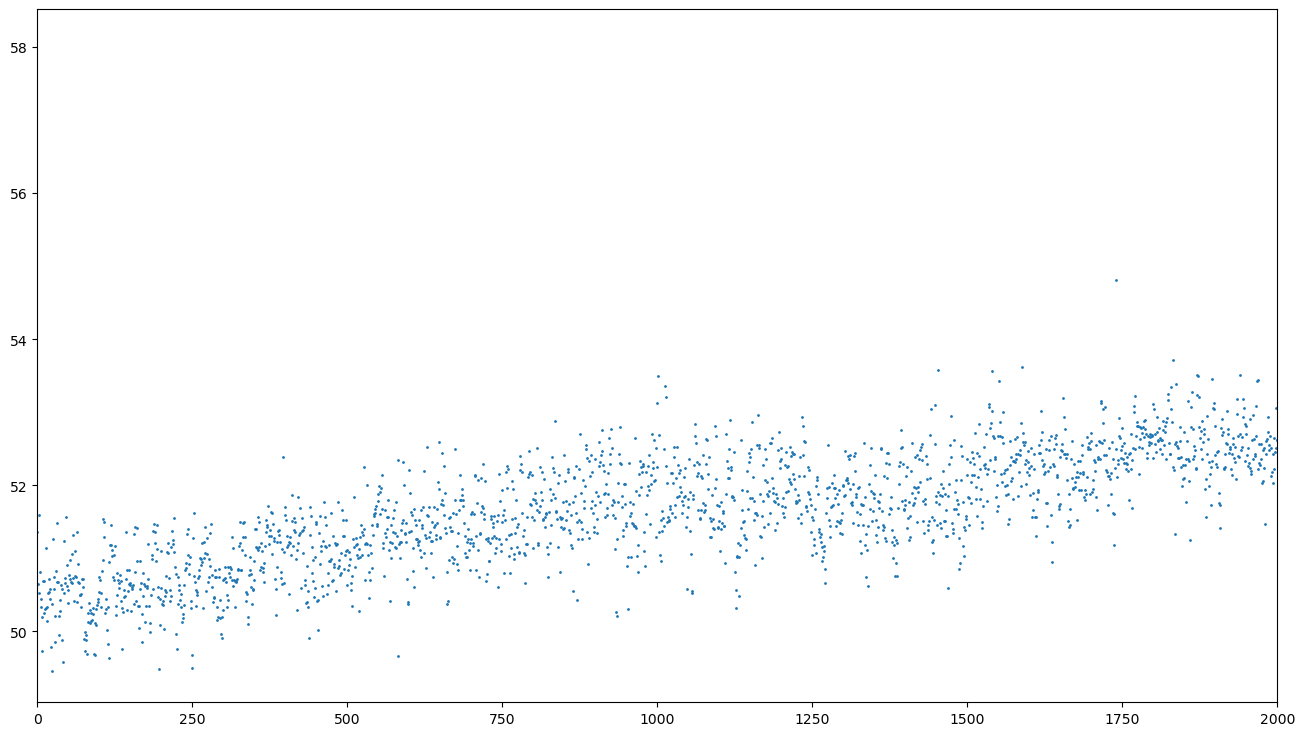

In [ ]:
plt.figure(figsize = (16,9))
plt.scatter(range(len(hrs)), hrs, s = 1)
plt.show()

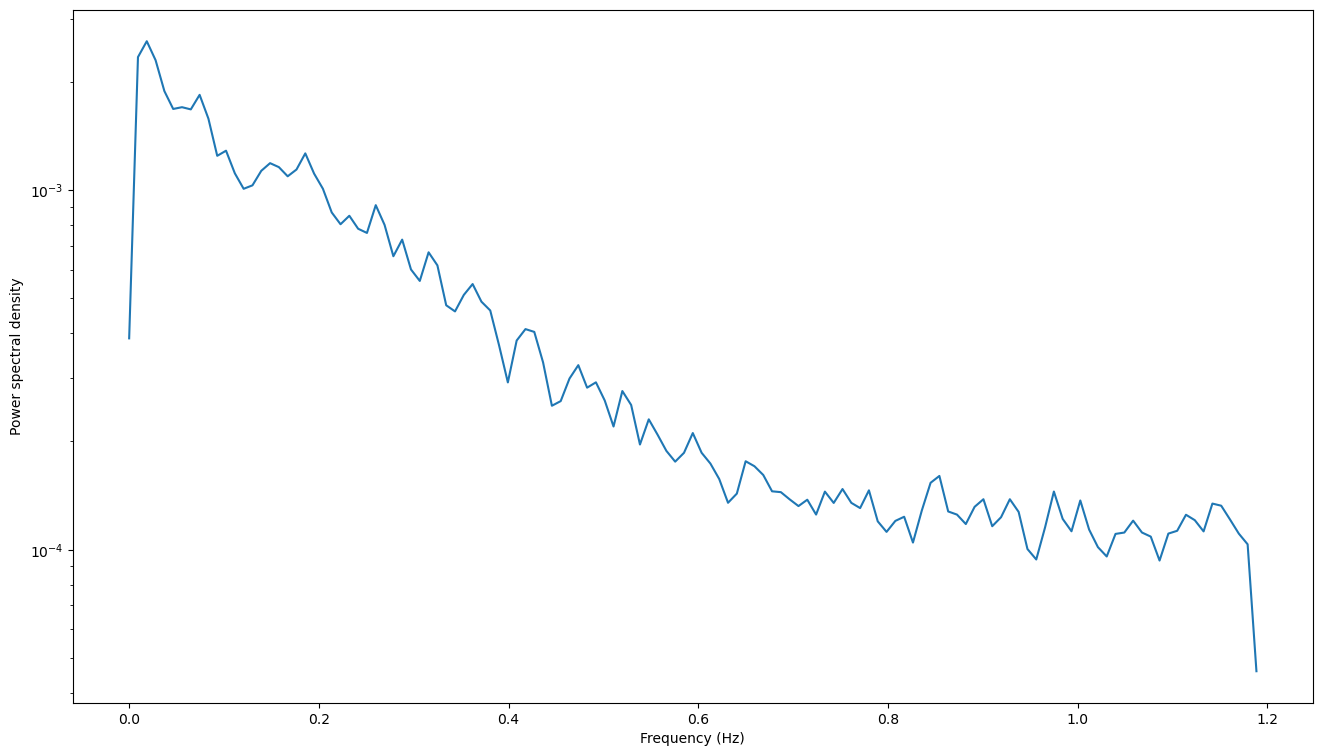

In [ ]:
# Get PSD using Welch's method
from scipy.signal import welch


plt.figure(figsize = (16,9))
f, Pxx = welch( 120/ np.array(hrs), fs=1/(oog.sequence_manager.reference_period/120))
plt.semilogy(f, Pxx)
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power spectral density")
plt.show()